# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №5 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 декабря 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 декабря, -4 балла после 06:00 24 декабря, -6 баллов после 06:00 31 декабря -8 баллов  после 06:00 7 января


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (6 баллов)

###### Боевое применение (2 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

# Определяем, что вам досталось

Укажите свою фамилию на русском языке в поле ниже.

In [4]:
import hashlib

def lucky_hash(text):
    return int(hashlib.md5(text.encode('utf-8')).hexdigest()[:8], 16) 

USER_NAME = u"Гарькавый".lower()

ALGORITHMS = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - число кластеров)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)",]

print ("Имплементируйте алгоритм кластеризации %s"\
% (
    ALGORITHMS[lucky_hash(USER_NAME[::-1]) % 2]
) )

Имплементируйте алгоритм кластеризации Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)


Не стоит переживать из-за Вашего варианта. Технически оба алгоритма несложно реализовать.  EM алгоритма бояться не стоит, Вам будет нужно просто реализовать уже выведенные формулы для E и M шагов.

In [5]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

%load_ext pycodestyle_magic

Populating the interactive namespace from numpy and matplotlib
The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать один из двух популярных методов кластеризации: разделение смеси нормальных распределений или агломеративную кластеризацию. 

## Смесь нормальных распределений



Предполагаем, что наши данные порождены смесью $k$ нормальных распределений, то есть 

$$ p(\mathbf{x}) = \sum_k \pi_k \mathcal{N}(\mathbf{x} | \mathbf{\mu}_k, \mathbf{\Sigma}_k) $$,


где $\mathcal{N}$ - многомерное нормальное распределение размерности ${D}$:

$$\mathcal{N(\mathbf{x} | \mathbf{\mu}, \mathbf{\Sigma}}) = \frac{1}{(2 \pi)^{D/2}} \frac{1}{|\mathbf{\Sigma}|^{1/2}} \exp \left\{-\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \mathbf{\Sigma^{-1}} (\mathbf{x} - \mathbf{\mu})\right\}$$

**Параметры**  


${D}$-мерный вектор средних

$$\mathbf{\mu}$$

$D \times D$-мерная матрица ковариации   (симметричная)


$$\mathbf{\Sigma} = E[(\mathbf{x} - \mathbf{\mu})(\mathbf{x} - \mathbf{\mu})^T]$$



Необходимо оценить параметры $\pi_k, \mathbf{\mu_k}, \mathbf{\Sigma_k} $ для всех компонент смеси.  Сделать это можно с помощью EM алгоритма - алгоритма, который находит оценку максимального правдоподобия в задаче со скрытыми переменными. 

## Expectation Maximization

**I** До цикла проинциализировать случайно  $\mu_k, \Sigma_k, \pi_k$ ($\pi_k$ должны суммироваться в 1)

**E** Expectation: при фиксированных $\mu_k, \Sigma_k, \pi_k$
$$
p(z_k = 1| x_n ) = \gamma(z_{nk}) = \frac{\pi_k \mathcal{N} (\mathbf{x}_n | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N} (\mathbf{x}_n | \mu_j, \Sigma_j)}
$$
**M** Maximization: при фиксированных $\gamma(z_{nk})$
$$
N_k = \sum_{n=1}^N \gamma(z_{nk}), \;\; \mu_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) \mathbf{x}_n
$$
$$
\Sigma_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) (\mathbf{x}_n - \mu_k)(\mathbf{x}_n - \mu_k)^T
$$
$$
\pi_k = \frac{N_k}{N}
$$
**S** Остановиться при достижении сходимости

Номер кластера для $n$ объекта будем брать по принципу maximum a-posteriori, то есть относить объект к тому кластеру, у которого максимальна апостериорная вероятность:
$$ k_n =  \arg\underset{k}\max  p(z_k = 1| x_n ) =  \arg\underset{k}\max \gamma(z_{nk}) $$

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Для простоты будем использовать евклидово расстояние между объектами.



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***

Минимизируемый на каждом шаге функционал (посредством переопределения множеств $C_k$):

$$ L(C) = \sum_{k=1}^K\sum_{i\in C_k} ||x_i - \mu_k||^2 \rightarrow \min\limits_C $$

Вычисляемые на каждом шаге после этого центроиды:

$$\mu_k = \frac{1}{|C_k|} \sum _{x_n \in C_k} x_n$$

Очевидно, кол-во всевозможных разбиений $N$ точек на $k$ кластеров, т.е. кол-во всевозможных значений вектора labels_, равно $k^N$.

После каждого шага минимизации функционала его значение либо уменьшится (и разбиение изменится), либо не изменится (и разбиение не изменится). Если значение функционала не изменится, то ничего не изменится после пересчёта центроид, и так далее больше ничего не изменится. Значит, за не более, чем $k^N$ шагов алгоритм завершится, а значит, он придёт хотя бы к локальному минимуму.

Задача 2. Сходимость EM.

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?



***Ваше решение здесь***

После каждого шага правдоподобие либо увеличивается, либо не меняется. Следовательно, алгоритм будет сходиться, если правдоподобие системы ограничено.

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***

$|a - b| =
  \begin{cases}
    a - b, & a \ge b \\
    b - a, & a \le b 
  \end{cases}$
 
$\quad$ 1) Выразим min через модуль:

$\quad$ Распишем a и b таким образом:

$b = \frac{1}{2} (a + b) - \frac{1}{2} (a - b), \quad a \ge b$

$a = \frac{1}{2} (a + b) - \frac{1}{2} (b - a), \quad a \le b$

$\quad$ Обобщим для обоих случаев:

$$\min(a, b) = \frac{1}{2} (a + b) - \frac{1}{2} |a - b| $$

$\quad$ 2) Выразим max через модуль:

$\quad$ Распишем a и b таким образом:

$a = \frac{1}{2} (a + b) + \frac{1}{2} (a - b), \quad a \ge b$

$b = \frac{1}{2} (a + b) + \frac{1}{2} (b - a), \quad a \le b$

$\quad$ Обобщим для обоих случаев:

$$\max(a, b) = \frac{1}{2} (a + b) + \frac{1}{2} |a - b| $$

$\quad$ 3) Из определения $d_{\min}$, $d_{\max}$ следует:

$d_{\min}(U \cup V, S) = \min\{d_{\min}(U, S), d_{\min}(V, S)\} $

$d_{\max}(U \cup V, S) = \max\{d_{\max}(U, S), d_{\max}(V, S)\} $

Выразим здесь $\min$, $\max$ через модуль и получим данные в задаче формулы.

# Реализация алгоритма кластеризации  (6 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [6]:
def pdist_idx(i, j, n):
    """
    return index for distance between X[i] and X[j] in "pdist(X) + [0]",
    where len(X) == n
    """
    if i == j:
        return -1
    I, J = (i, j) if i < j else (j, i)
    return ((2 * n - I - 3) * I) // 2 + J - 1


def pdist_row_gen(i, n):
    """
    generate all indices of "i-th row/column" in pdist condensed matrix
    """
    idx = i - 1
    d = n - 1
    for _ in range(i):
        d -= 1
        yield idx
        idx += d
    yield -1
    yield from range(idx + 1, idx + n - i)


def pdist_row(i, n):
    return np.array(list(pdist_row_gen(i, n)))


def pdist_rowcol(k, n):
    """
    inverse function for pdist_idx
    """
    import math

    def calc_row_idx(k, n):
        return int(math.ceil(
            (1 / 2.)
            * (
                - (-8 * k + 4 * n ** 2 - 4 * n - 7) ** 0.5
                + 2 * n - 1
            ) - 1
        ))

    def elem_in_i_rows(i, n):
        return i * (n - 1 - i) + (i*(i + 1))/2

    def calc_col_idx(k, i, n):
        return int(n - elem_in_i_rows(i + 1, n) + k)

    i = calc_row_idx(k, n)
    j = calc_col_idx(k, i, n)
    return i, j

In [7]:
from sklearn.base import BaseEstimator, ClusterMixin
from scipy.spatial.distance import pdist


class Clustering(BaseEstimator, ClusterMixin):
    """
    My agglomerative clustering algorithhm
    """

    def __init__(self, n_clusters=2, linkage="single"):
        self.n_clusters = n_clusters
        if linkage == "single":
            self.linkage = self.linkage_single
            self.linkage_coefs = self.linkage_coefs_single
        elif linkage == "complete":
            self.linkage = self.linkage_complete
            self.linkage_coefs = self.linkage_coefs_complete
        elif linkage == "average":
            self.linkage = self.linkage_average
            self.linkage_coefs = self.linkage_coefs_average

    def linkage_single(self, X, mask_i, mask_j, dists=None):
        if dists is None:
            dists = pairwise_distances(X[mask_i], X[mask_j])
        return dists.min()

    def linkage_complete(self, X, mask_i, mask_j, dists=None):
        if dists is None:
            dists = pairwise_distances(X[mask_i], X[mask_j])
        return dists.max()

    def linkage_average(self, X, mask_i, mask_j, dists=None):
        if dists is None:
            dists = pairwise_distances(X[mask_i], X[mask_j])
        return dists.mean()

    def linkage_coefs_single(self, k, l):
        return 0.5, 0.5, 0, -0.5

    def linkage_coefs_complete(self, k, l):
        return 0.5, 0.5, 0, 0.5

    def linkage_coefs_average(self, k, l):
        union_sum = np.any(self.clusters[[k, l]], axis=0).sum()
        return self.clusters[k].sum() / union_sum, \
            self.clusters[l].sum() / union_sum, 0, 0

    def fit(self, X, y=None):
        """
        Use data matrix X to compute model parameters
        """
        self.X_len = len(X)
        cur_n = self.X_len
        self.clusters = np.identity(self.X_len, dtype=bool)
        dists = np.append(pdist(X), 0.)
        iter_n = 0
        while cur_n > self.n_clusters:
            iter_n += 1
            # индексы ближайших друг к другу кластеров в self.clusters
            k, l = pdist_rowcol(dists[:-1].argmin(), cur_n)
            k, l = (k, l) if k < l else (l, k)
            # merge(k, l):
            # на самом деле, надо в матрице squareform(pdist[:-1]):
            # 1) взять строки k и l
            # 2) заменить строку k на функцию от строк k и l по ф-ле
            #   Ланса-Вильямса
            # 3) сделать то же самое со столбцами вместо строк
            # 4) удалить строку и столбец l
            # но это все производится на уплотненной матрице pdist[:-1]
            #   вместо квадратной матрицы
            a_k, a_l, b, c = self.linkage_coefs(k, l)
            d_kl = dists[pdist_idx(k, l, cur_n)]
            d_k_idx = pdist_row(k, cur_n)
            d_l_idx = pdist_row(l, cur_n)
            dists[pdist_row(k, cur_n)] = (
                a_k * dists[d_k_idx]
                + a_l * dists[d_l_idx]
                + b * d_kl
                + c * np.abs(dists[d_k_idx] - dists[d_l_idx])
            )
            # нуль в конце не удаляем
            dists = np.delete(dists, d_l_idx[d_l_idx >= 0])
            self.clusters[k] = np.any(self.clusters[[k, l]], axis=0)
            self.clusters = np.delete(self.clusters, l, axis=0)
            cur_n -= 1
        self.labels_ = np.zeros(self.X_len, dtype=int)
        for k in range(self.n_clusters):
            self.labels_[self.clusters[k]] = k
        return self

# для agglomerative clustering не нужен predict
# (т.к. для этого надо хранить в классе обучающую выборку).
# да и в sklearn.cluster.AgglomerativeClustering его нет.
# я так понял, это для задания на EM.
#     def predict(self, X):
#         """
#         Using computed model parameters predict cluster
#         for all objects from X
#         """
#         pass

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

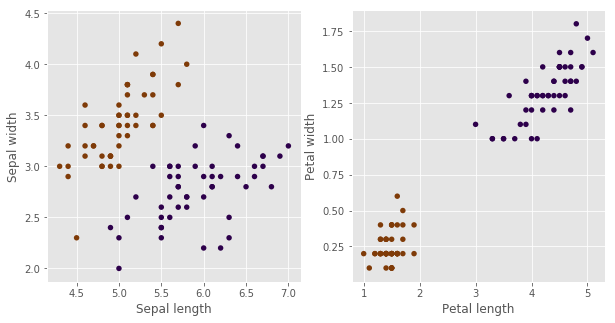

In [8]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [11]:
pred_iris = Clustering(n_clusters=2, linkage="average").fit_predict(x_iris)
# pred_iris = [ 0 ] * len(y_iris)
print ("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 1.00


In [12]:
# Давайте проверим, как справляются sklearn реализации
sklearn_gmm = GaussianMixture(n_components=2)
gmm_t0 = time.time()
sklearn_gmm.fit(x_iris)
gmm_diff = time.time() - gmm_t0
gmm_score = smt.adjusted_rand_score(y_iris, sklearn_gmm.predict(x_iris))

sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("GMM score {}. GMM time {}. AGGL score {}. AGGL time {}".format(gmm_score, gmm_diff, aggl_score, aggl_diff))

GMM score 1.0. GMM time 0.03622102737426758. AGGL score 1.0. AGGL time 0.0040318965911865234


Сверьте Ваш алгоритм с этими числами. Уверен, что у Вас получится не хуже!

# Боевое применение (2  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для анализа реальной задачи!

Важное замечание: в этой части задания студенту самому предлагается разобраться с данными и их форматом в качестве полезного упраженения. Не принимайте это близко к сердцу :)

Ввозьмем датасет различных стран.  
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   


Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам. 
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   

Необходимо показать, какие страны попали в общий кластер в и объяснить из-за каких признаков это произошло. Если страны были в одном кластере, а спустя несколько лет разъехались по разным кластерам, попробуйте это объяснить. 

In [13]:
# Место для Вашего кластерного анализа

In [14]:
df = pd.read_csv("WDI_csv/WDIData.csv")

In [15]:
years = range(1960, 2017+1)
n_years = len(years)

countries_groupby = df.groupby("Country Name")
contries_codes_names = df[
    ["Country Code", "Country Name"]
].drop_duplicates().values

countries = contries_codes_names[:, 1] # names
n_countries = len(countries)

indicators_codes_names = \
    countries_groupby.get_group(countries[0])[
        ["Indicator Code", "Indicator Name"]
    ].values

indicators = indicators_codes_names[:, 1] # names
n_indicators = len(indicators)

code2name_dict = dict(contries_codes_names)
code2name_dict.update(dict(indicators_codes_names))
name2code_dict = dict(contries_codes_names[:, ::-1])
name2code_dict.update(dict(indicators_codes_names[:, ::-1]))
code2name = np.vectorize(lambda code: code2name_dict[code])
name2code = np.vectorize(lambda name: name2code_dict[name])

In [16]:
df_years = []
for year in years:
    df_year_countries = []
    for country in countries:
        data = countries_groupby.get_group(country)[str(year)].values
        df_year_country = pd.DataFrame(
            columns=[country], index=indicators, data=data
        ).transpose()
        df_year_countries.append(df_year_country)
    df_year = pd.concat(df_year_countries, sort=False)
    df_years.append(df_year)

In [17]:
del df

In [19]:
df_years[-1].head()

,"2005 PPP conversion factor, GDP (LCU per international $)","2005 PPP conversion factor, private consumption (LCU per international $)",Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)","Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+)","Account ownership at a financial institution or with a mobile-money-service provider, older adults (% of population ages 25+)",...,"Women participating in the three decisions (own health care, major household purchases, and visiting family) (% of women age 15-49)",Women who believe a husband is justified in beating his wife (any of five reasons) (%),Women who believe a husband is justified in beating his wife when she argues with him (%),Women who believe a husband is justified in beating his wife when she burns the food (%),Women who believe a husband is justified in beating his wife when she goes out without telling him (%),Women who believe a husband is justified in beating his wife when she neglects the children (%),Women who believe a husband is justified in beating his wife when she refuses sex with him (%),Women who were first married by age 15 (% of women ages 20-24),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%)
Arab World,NaN,NaN,NaN,NaN,NaN,NaN,37.165211,25.635403,48.328518,42.542046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Caribbean small states,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Central Europe and the Baltics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Early-demographic dividend,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.378037
East Asia & Pacific,NaN,NaN,NaN,NaN,NaN,NaN,73.693977,71.484467,75.922256,74.519600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# посчитаем min, max, mean, std сразу по всем годам,
#   чтобы при нормализации или стандартизации кластеризация
#   по годам была более однородная
df_years_concat = pd.concat(df_years)
df_years_concat.fillna(df_years_concat.mean())
df_min = df_years_concat.min()
df_max = df_years_concat.max()
df_mean = df_years_concat.mean()
df_std = df_years_concat.std()
del df_years_concat

In [21]:
from itertools import permutations
from sklearn.metrics import mean_absolute_error as mae


def enum_clusters(labels_new, labels_old, year_new_idx, n_clusters):
    """
    постараться перенумеровать новый набор кластеров так,
    чтобы была прямая связь со старым набором кластеров
    """
    perm_list = list(map(list, permutations(range(n_clusters))))
    # матрица попарных пересечений кластеров из старого и нового разбиений
    intersects = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            mask_i = labels_old == i
            mask_j = labels_new == j
            intersects[i, j] = ((mask_i & mask_j).sum()
                                / (mask_i.sum() + mask_j.sum()))
    perm_intersects = np.array(list(map(
        lambda perm: intersects[perm, range(n_clusters)].sum(),
        perm_list
    )))
    best_perm_idx = np.argmax(perm_intersects)
    best_perm = perm_list[best_perm_idx]
    if best_perm != list(range(n_clusters)):
        rename_labels = np.vectorize(lambda x: best_perm[int(x)])
        return rename_labels(labels_new)
    else:
        return labels_new

In [23]:
countries_chosen_idx = countries != 'World'
countries_chosen = countries[countries_chosen_idx]
n_countries_chosen = countries_chosen_idx.sum()
indicators_chosen = set(indicators)
nan_ratio_thres = 0.09
# выкидываем все столбцы, где доля нанов больше чем nan_ratio_thres
# 1.0 ~ почти ничего не выкидываем
# 0.0 ~ выкидываем все столбцы
for i in range(n_years):
    df_ = df_years[i].loc()[countries_chosen_idx, :]
    nan_ratios = df_.isnull().sum(axis=0) / df_.shape[1]
    indicators_chosen -= set(df_.columns[nan_ratios >= nan_ratio_thres])
indicators_chosen -= {ind for ind in indicators_chosen
                      if ind.find('Population') >= 0 and ind.find('%') < 0}
indicators_chosen = list(indicators_chosen)
print('\n'.join(indicators_chosen))
# набор индикаторов, по которым будем кластеризовать

Population ages 40-44, female (% of female population)
Population ages 50-54, female (% of female population)
Population ages 30-34, male (% of male population)
Population ages 0-4, male (% of male population)
Population ages 55-59, female (% of female population)
Rural population
Population ages 75-79, male (% of male population)
Population ages 70-74, male (% of male population)
Population ages 0-14 (% of total)
Population ages 75-79, female (% of female population)
Population ages 65-69, female (% of female population)
GDP per capita (current US$)
Population ages 0-4, female (% of female population)
Population ages 25-29, male (% of male population)
Population ages 80 and above, female (% of female population)
Population growth (annual %)
Population ages 60-64, female (% of female population)
Population, male (% of total)
Population ages 15-19, female (% of female population)
Population ages 10-14, female (% of female population)
Population in urban agglomerations of more than 1 mil

In [24]:
indicators_for_plot = [
    'GDP per capita (current US$)',
    'Official exchange rate (LCU per US$, period average)',
    'Population ages 15-64 (% of total)',
    'Population growth (annual %)',
    'Rural population (% of total population)',
    'Urban population (% of total)',
    'Urban population growth (annual %)'
]
indicators_for_plot = list(set(indicators_for_plot) & set(indicators_chosen))
# небольшой набор индикаторов для графиков в конце (plot.bar)

In [25]:
n_clusters = 8
clusters_labels_raw = np.zeros((n_years, n_countries_chosen))
for i in range(n_years):
    df_ = df_years[i].loc()[countries_chosen_idx, indicators_chosen]
    df_ = df_.fillna(df_.mean())
    df_ = (df_ - df_mean[indicators_chosen]) / df_std[indicators_chosen]
    X = df_.values
    aggl = Clustering(n_clusters=n_clusters, linkage="average")
    aggl_pred = aggl.fit_predict(X)
    clusters_labels_raw[i] = aggl_pred

In [26]:
clusters_labels = clusters_labels_raw.copy()

In [27]:
# в каждом году номера кластеров переставляются так, чтобы
#   соответствовать предыдущему году (чтобы на графике ниже
#   часто не менялись цвета, по сути, одних и тех же кластеров).
# но т.к. для каждого года рассматриваются всевозможные
# перестановки номеров кластеров, сложность этой операции факториальная
if n_clusters <= 8:
    for i in range(1, n_years):
        print(f"{years[i]}", end=" ")
        clusters_labels[i] = enum_clusters(
            clusters_labels[i], clusters_labels[i - 1],
            i, n_clusters
        )

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 

In [28]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# менять этот сид чтобы перемешать цвета
np.random.seed(2)
cmap = np.random.permutation(sns.color_palette("hls", n_clusters))
cmap = [tuple(color) for color in cmap]

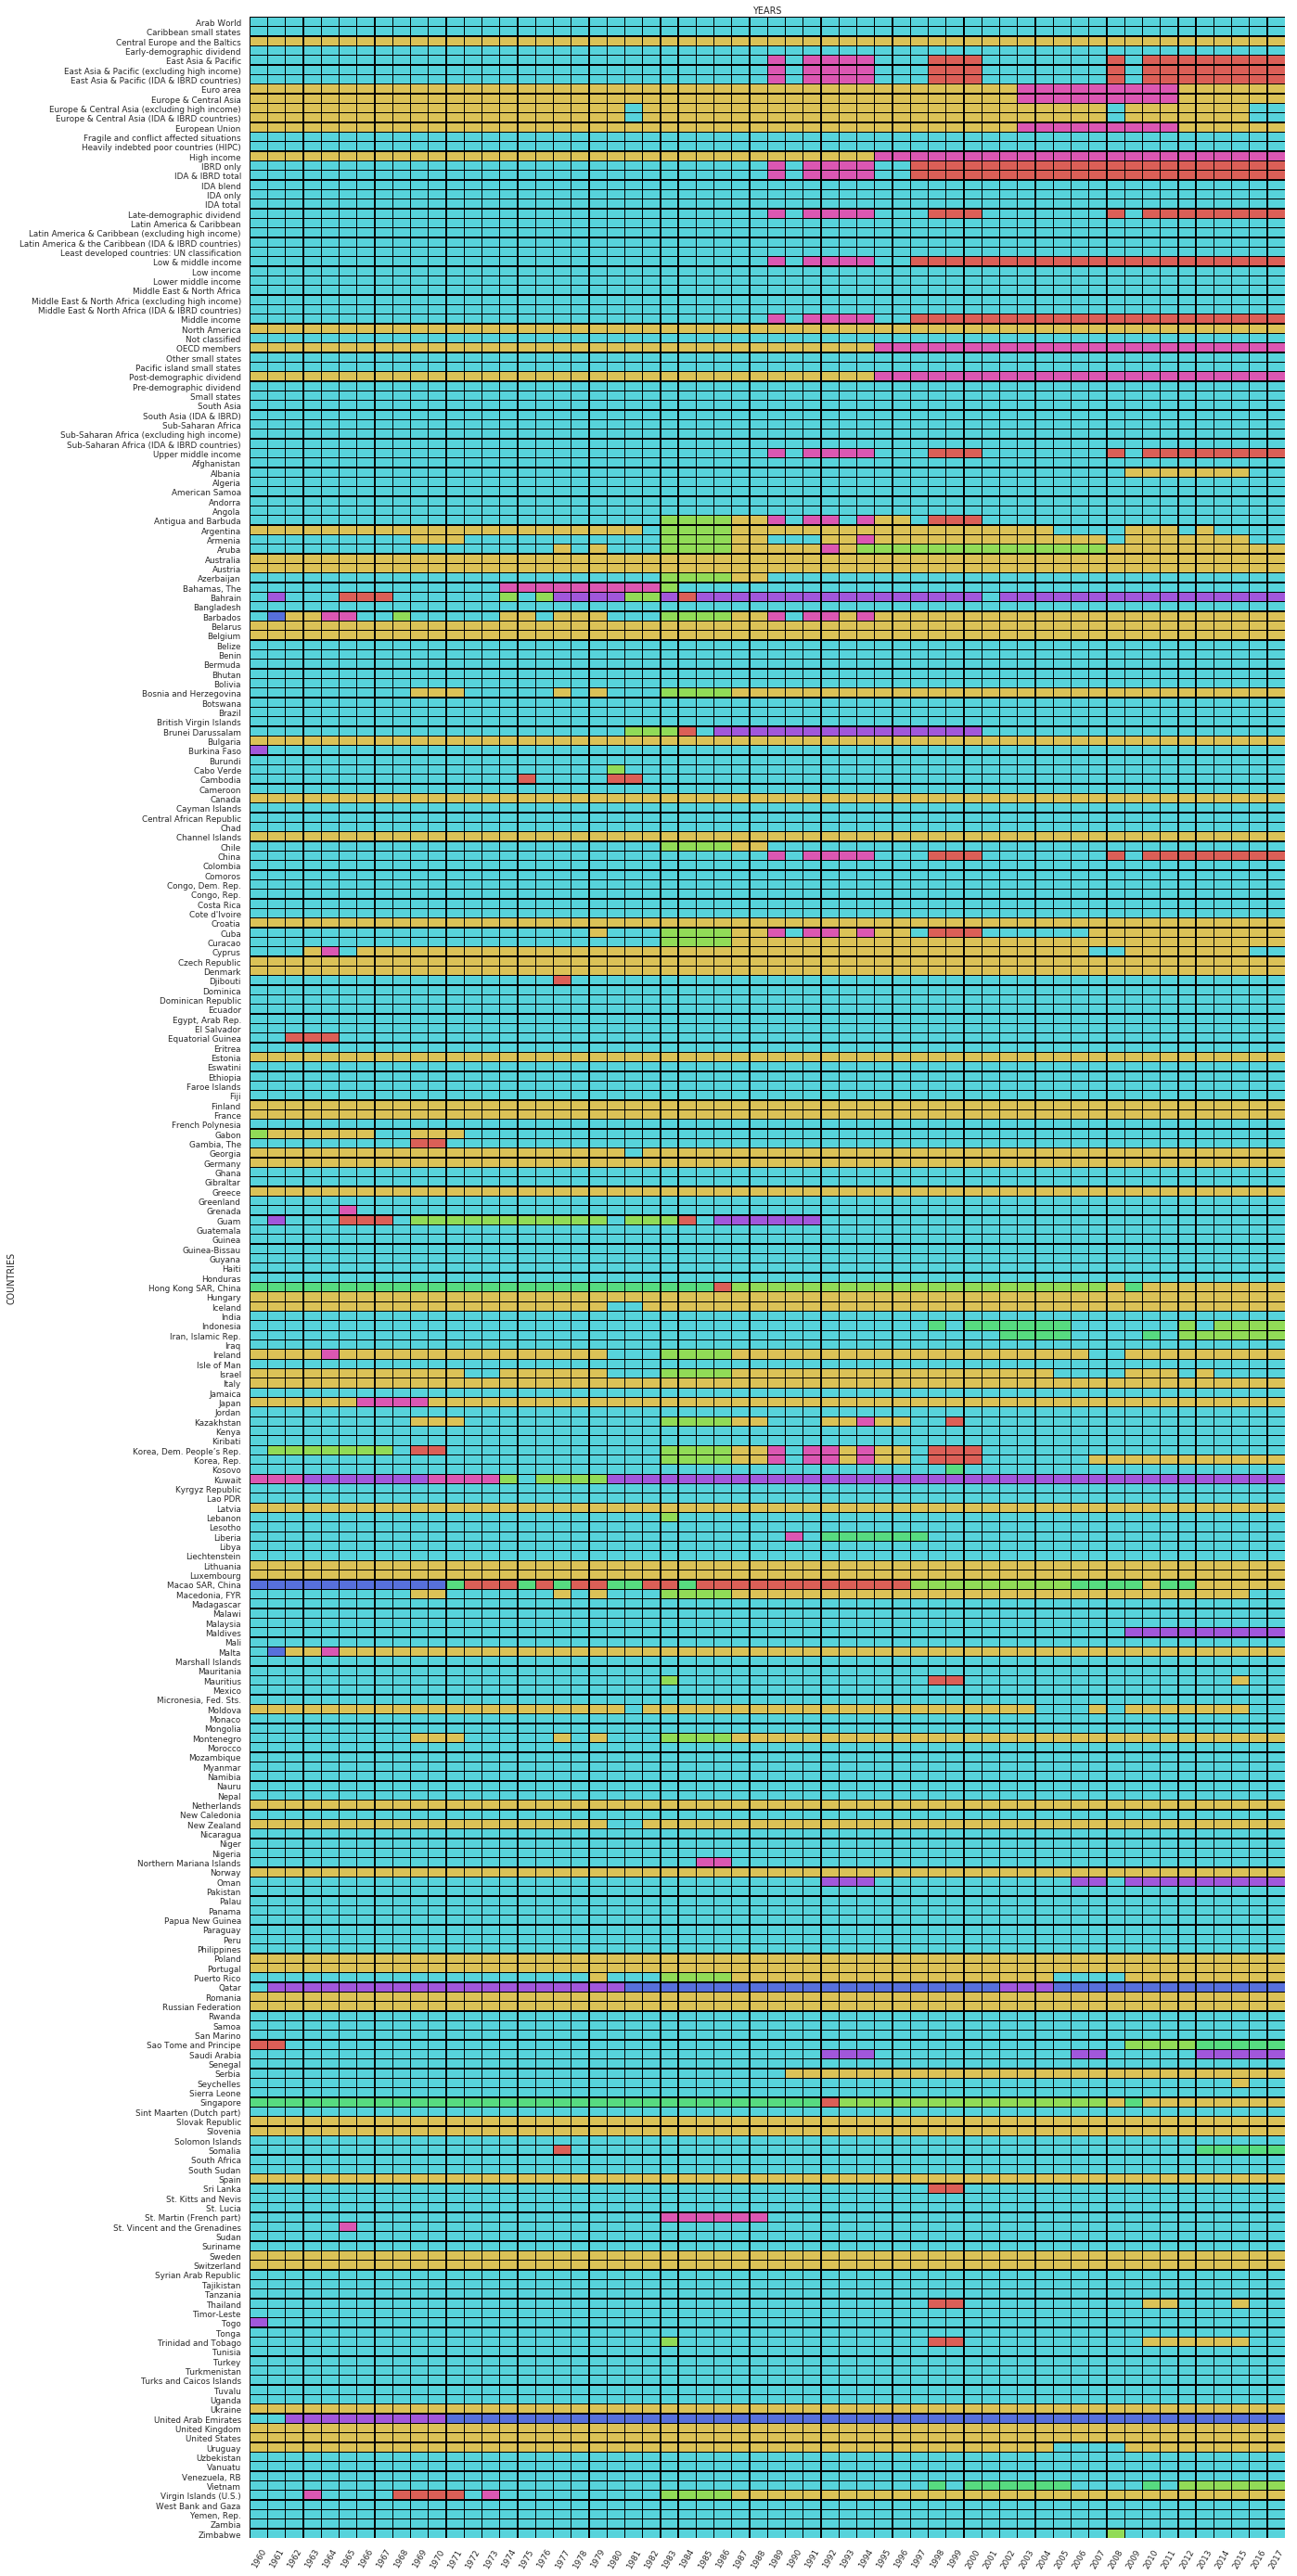

In [29]:
# строим график-таблицу по всем странам и годам, в каких кластерах
#   они находились.
# получилось, что почти всё время выделялось два больших кластера:
# в одном находятся в основном более бедные страны Африки,
#   Азии, Южной Америки (голубой),
# а в другом - более богатые страны Европы и Северной Америки
#   (и немного Южной) (желтый).
# иногда в отдельный кластер выделяются некоторые страны Персидского залива.
# также до некоторого момента в отдельный кластер выделяются Гонконг и Сингапур.
# можно заметить, что, например, в 1983 к желтому кластеру
#   присоединилось много стран (которые перед этим оформились
#   в зеленый кластер), а в начале 90-х к желтому кластеру
#   присоединилась Сербия.

sns.set(font_scale=0.8, rc={'figure.figsize': (20, 50)})
ax = sns.heatmap(clusters_labels.T, cmap=cmap,
                 cbar=False, linewidths=.3, linecolor='black')

ax.set_ylabel('countries'.upper())
ax.set_xlabel('years'.upper())

ax.xaxis.set_label_position('top')
locs, labels = plt.xticks()
plt.xticks(locs, years)
locs, labels = plt.xticks()
plt.setp(labels, rotation=60)
locs, labels = plt.yticks()
plt.yticks(locs, countries_chosen)

plt.show()

# так вышло, что кластеризация происходила в основном по признакам,
#   связанным с населением (но я постарался добавить и другие).
# при большом количестве признаков кластеризация выходит бедная.

/home/garx/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/garx/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/garx/anaconda3/lib/python3.7/site-packages/matplotlib/cb

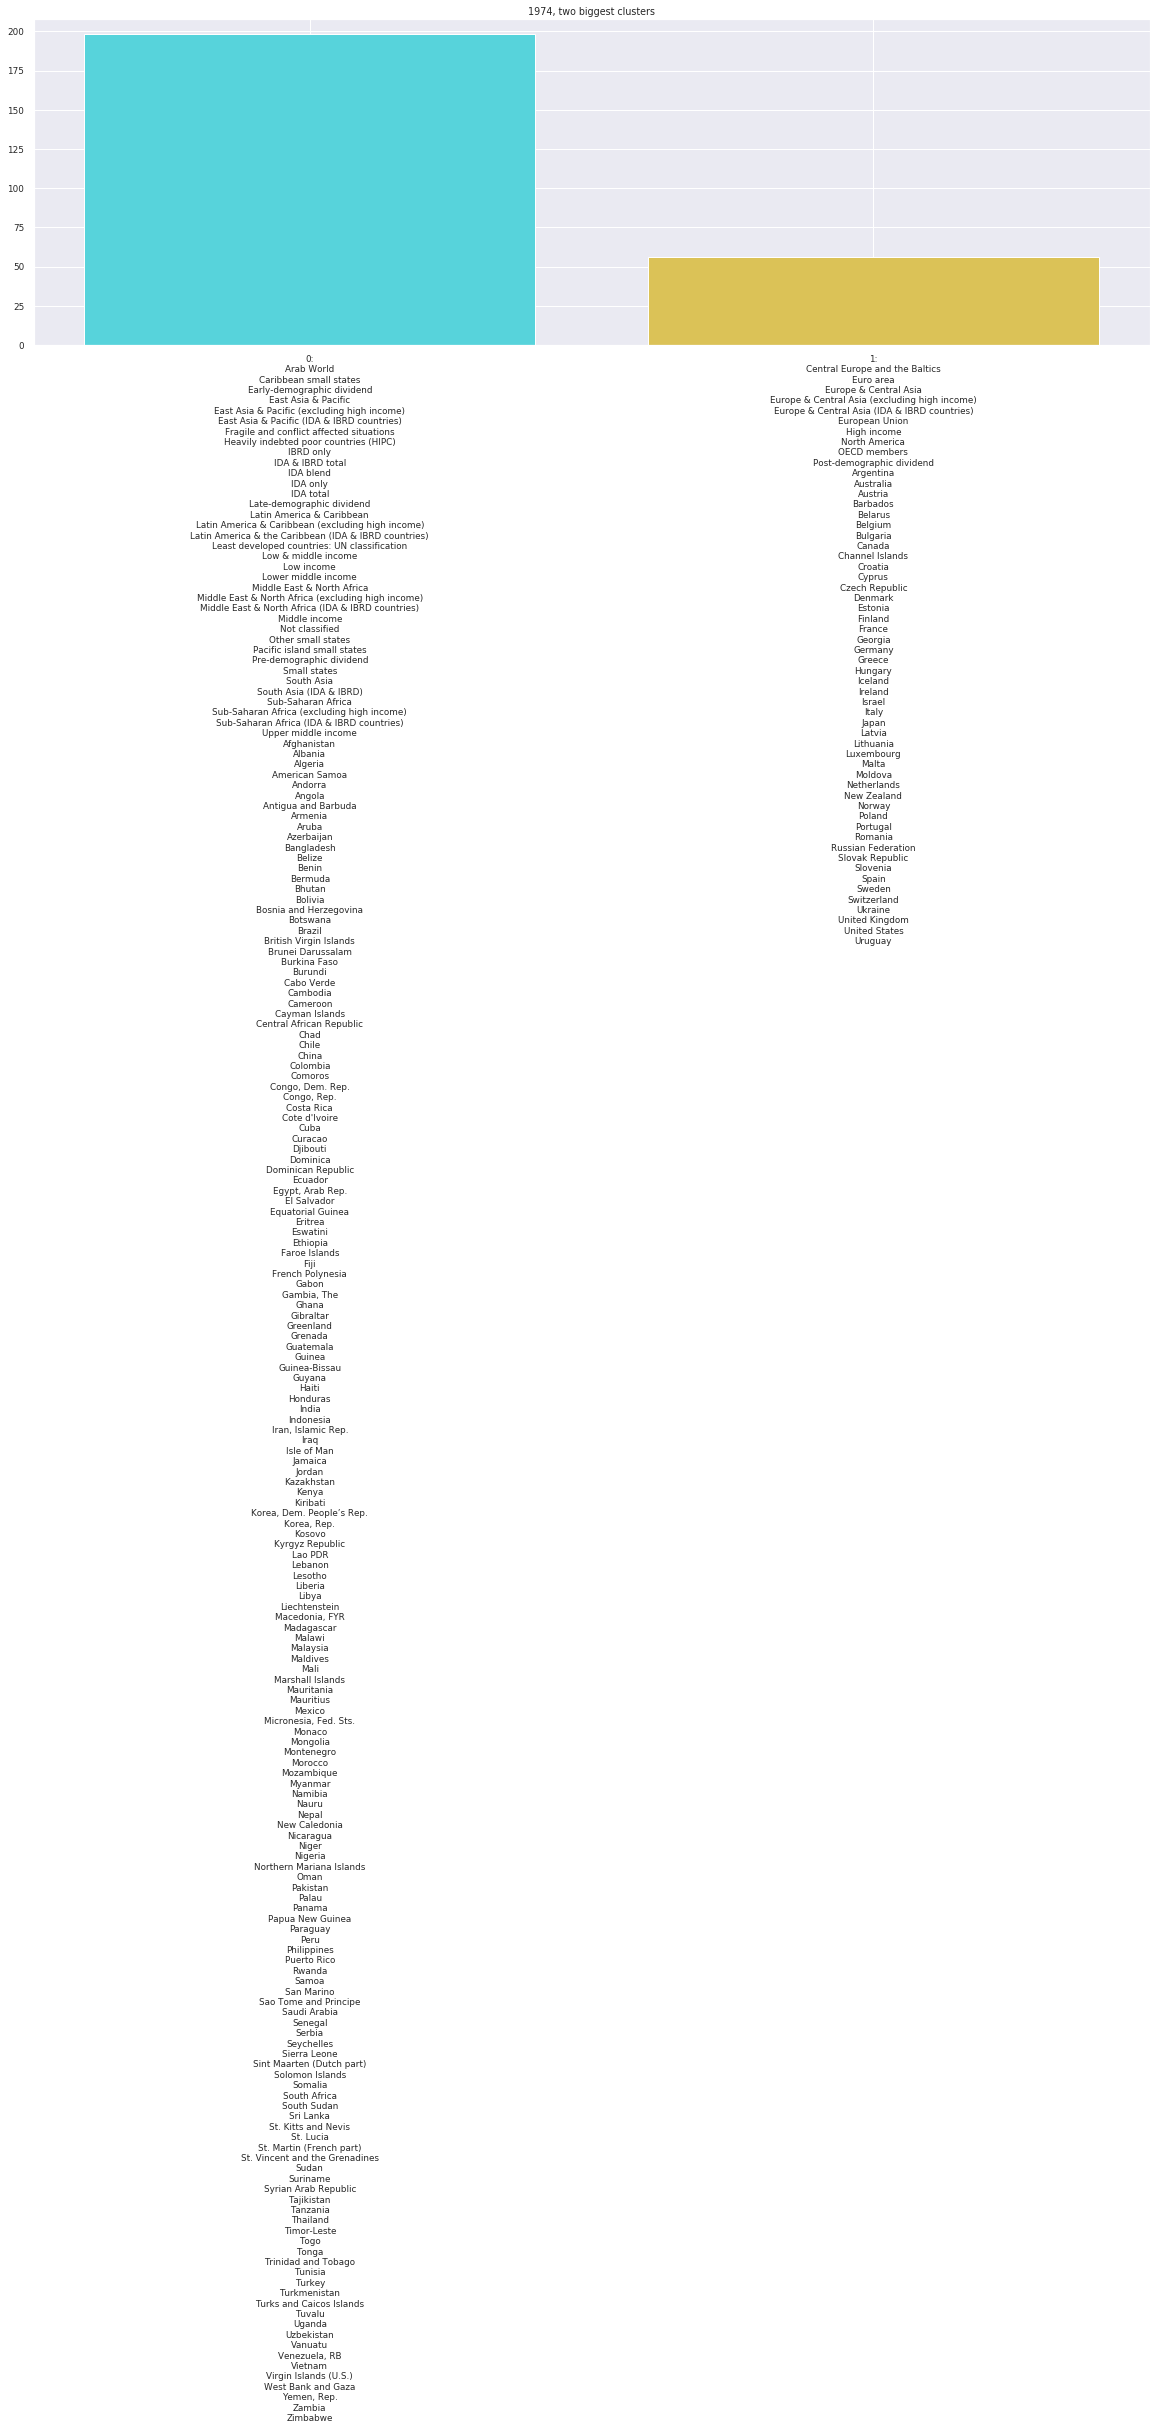

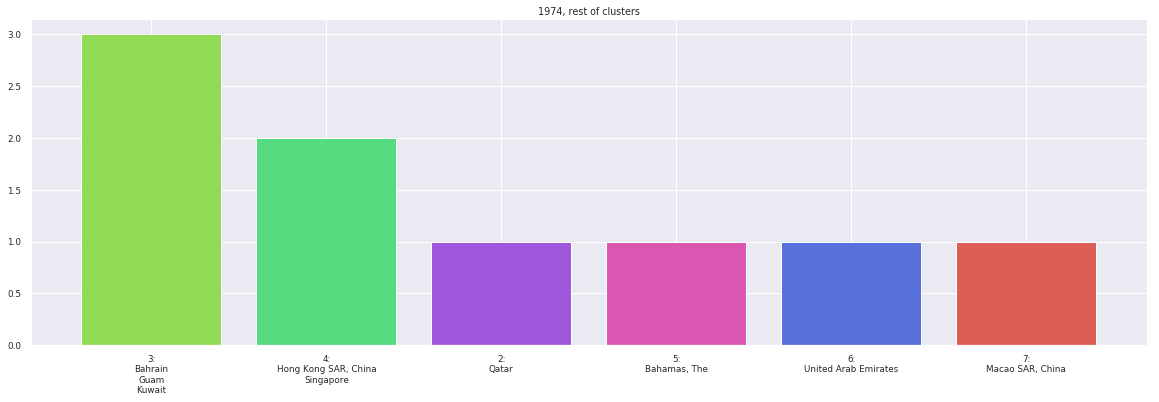

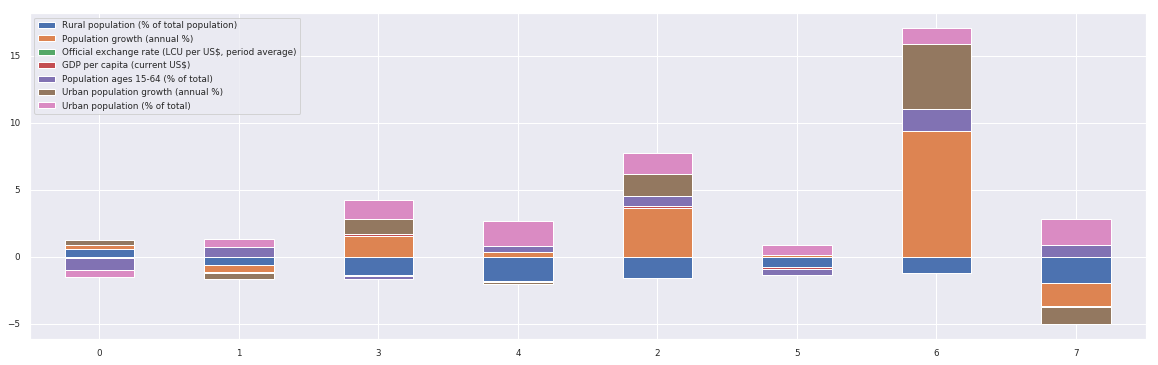

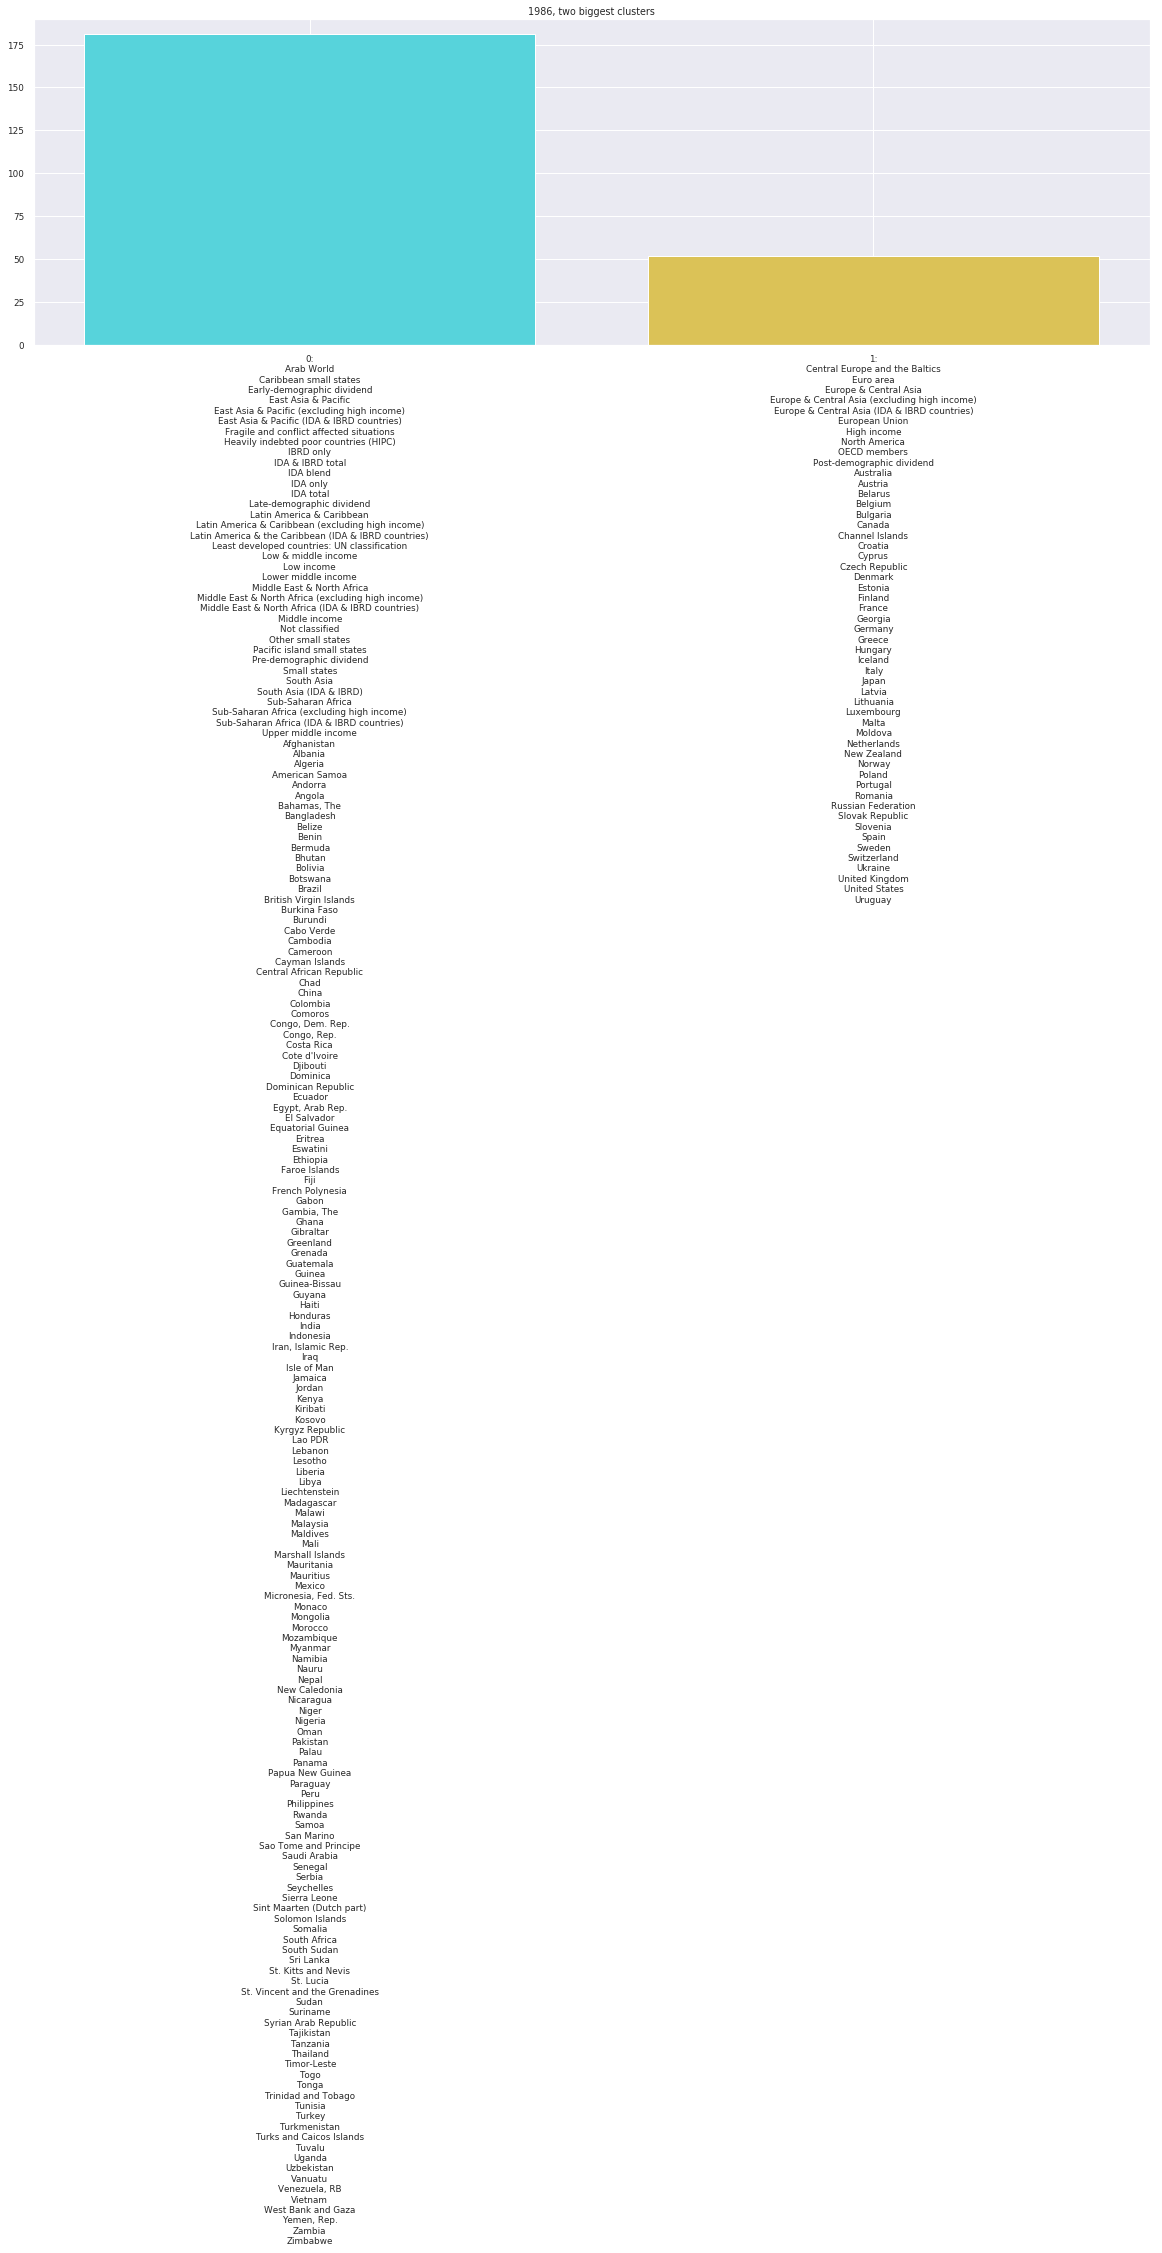

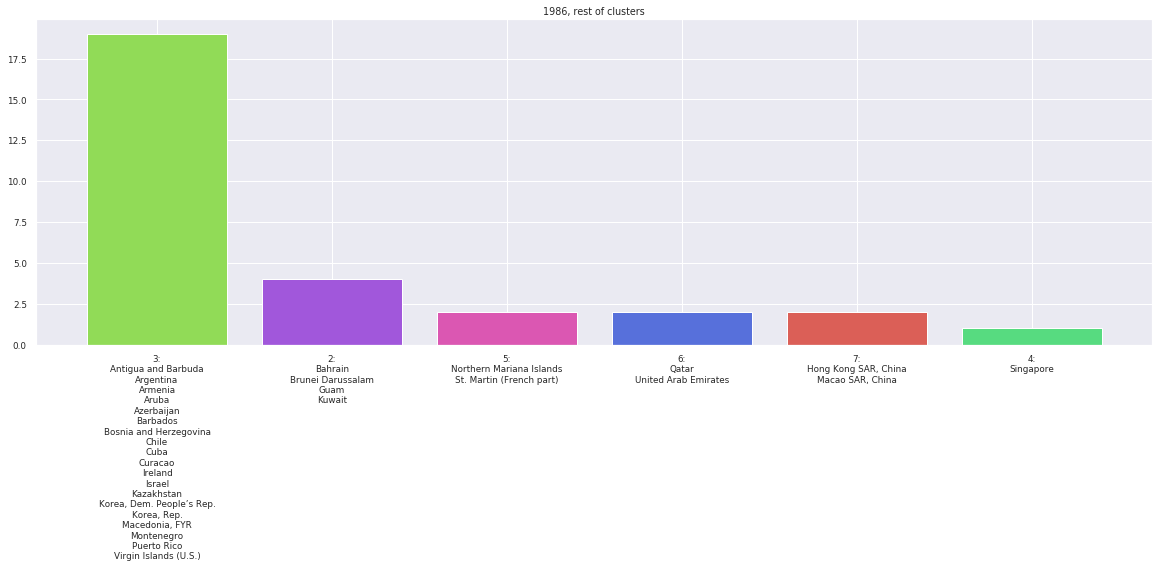

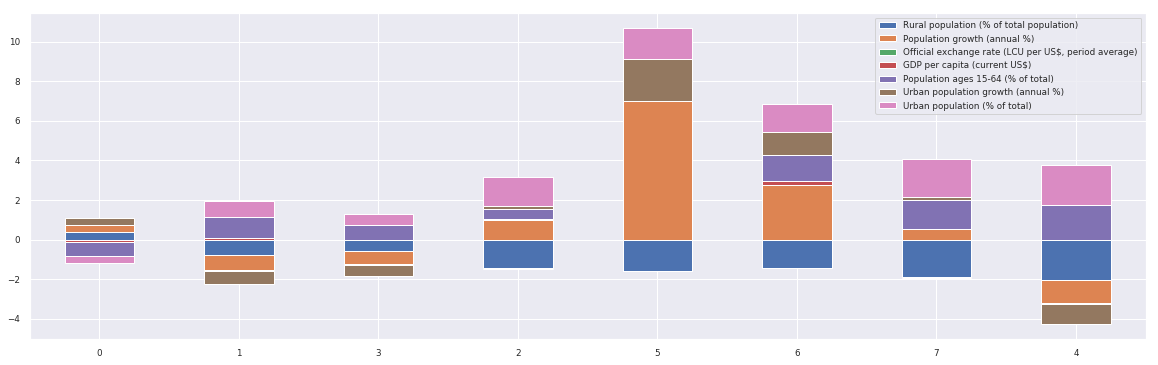

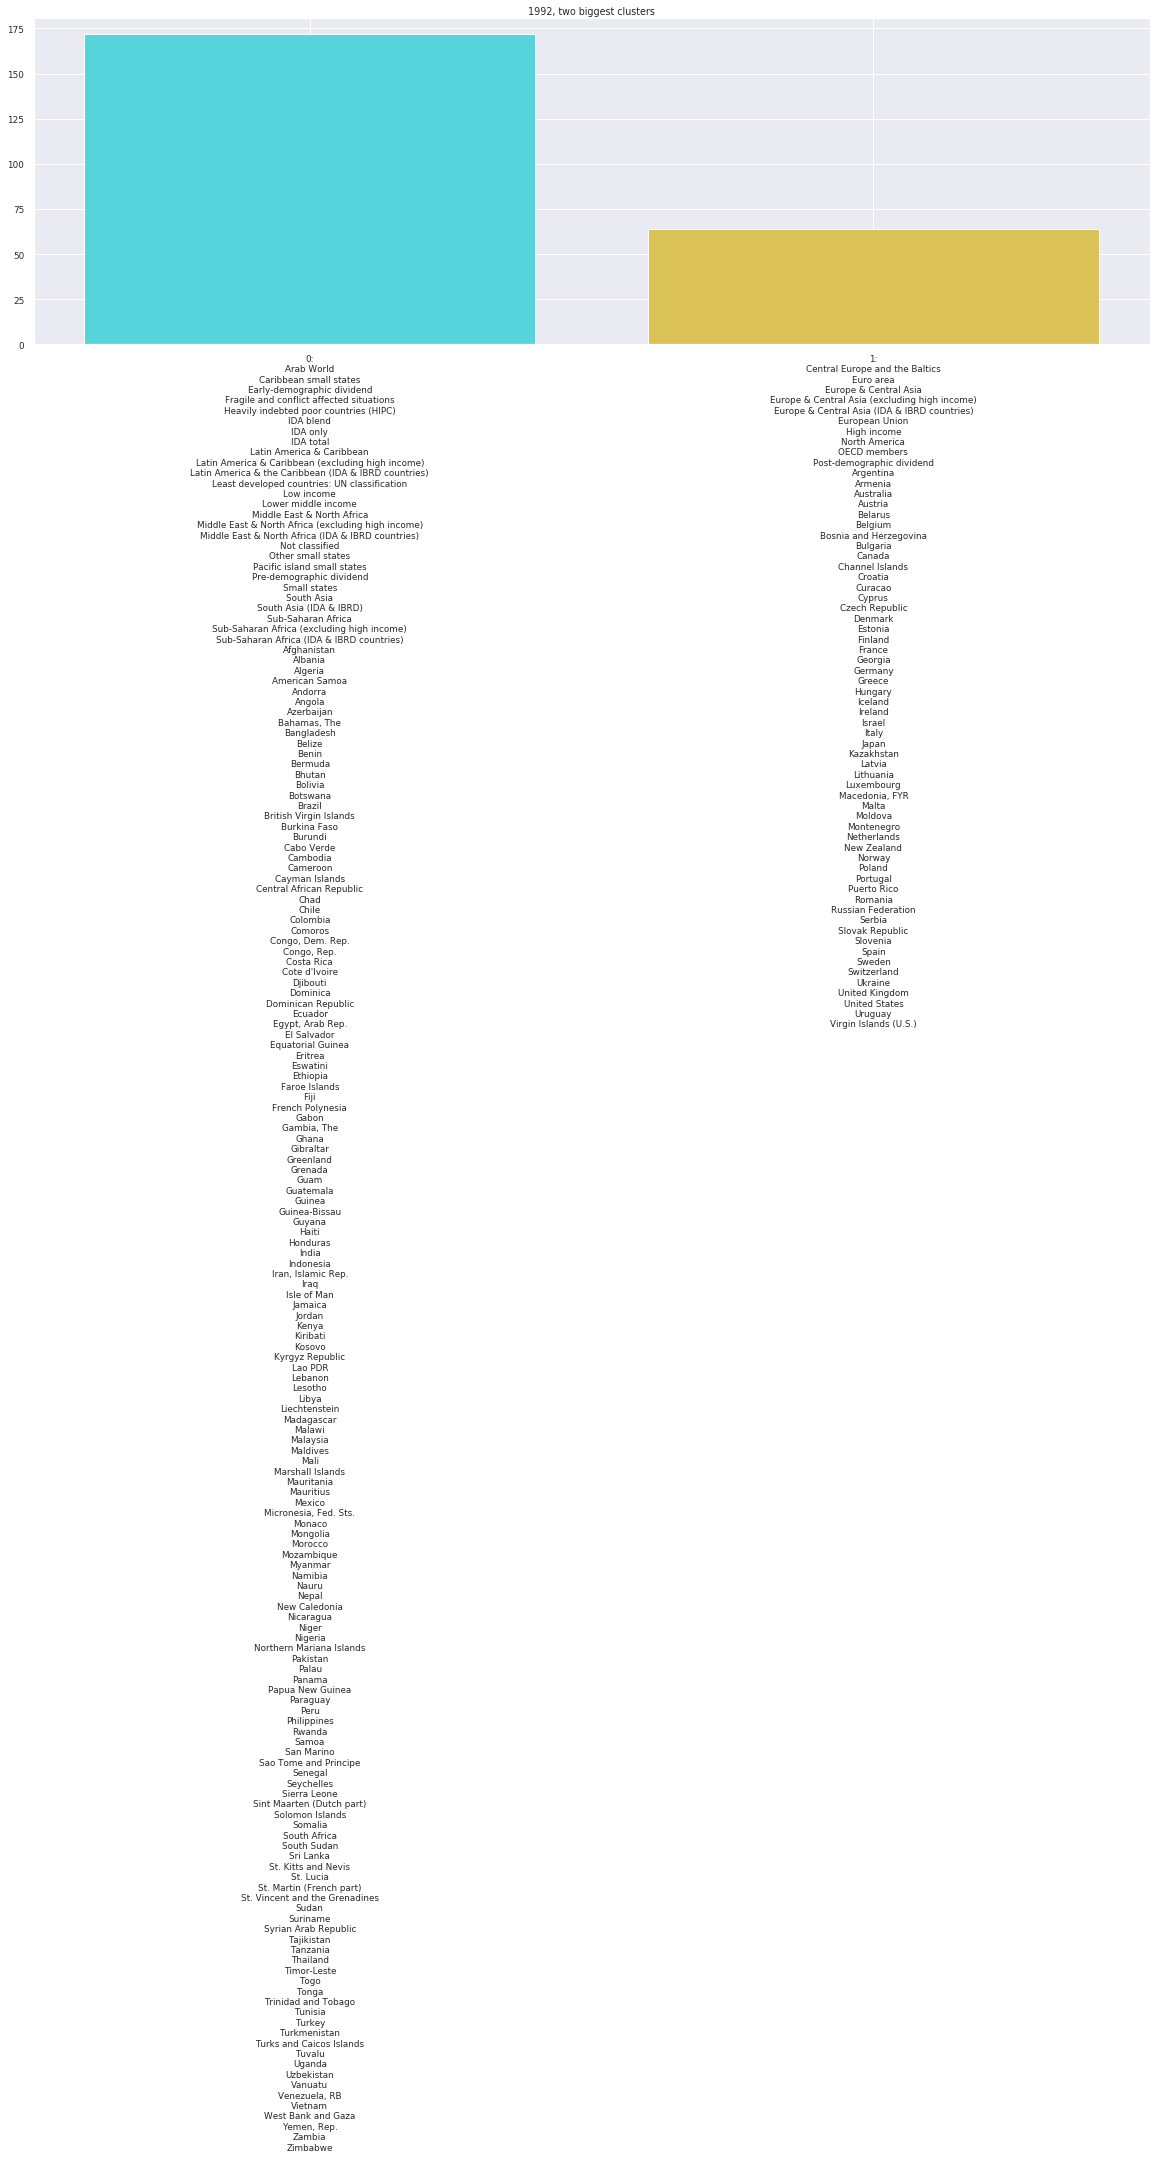

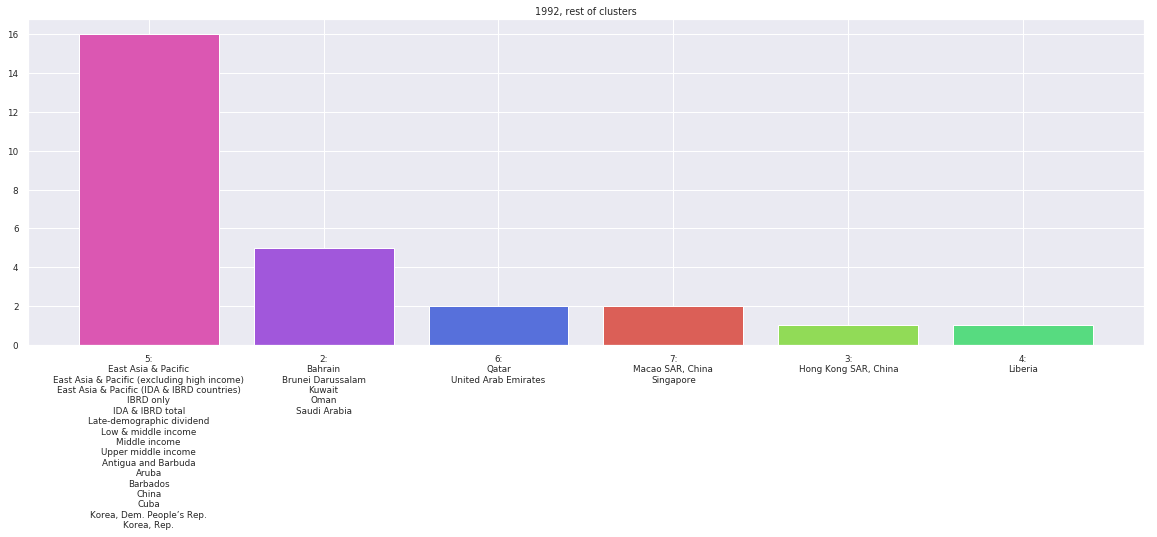

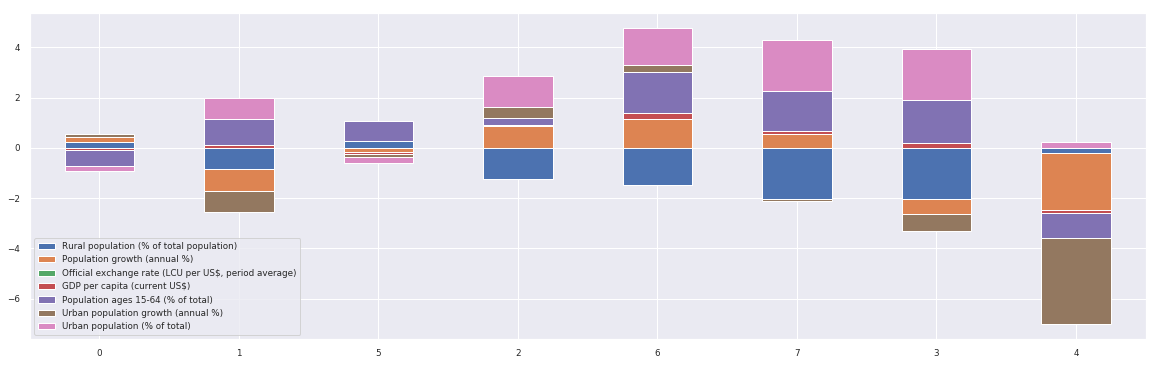

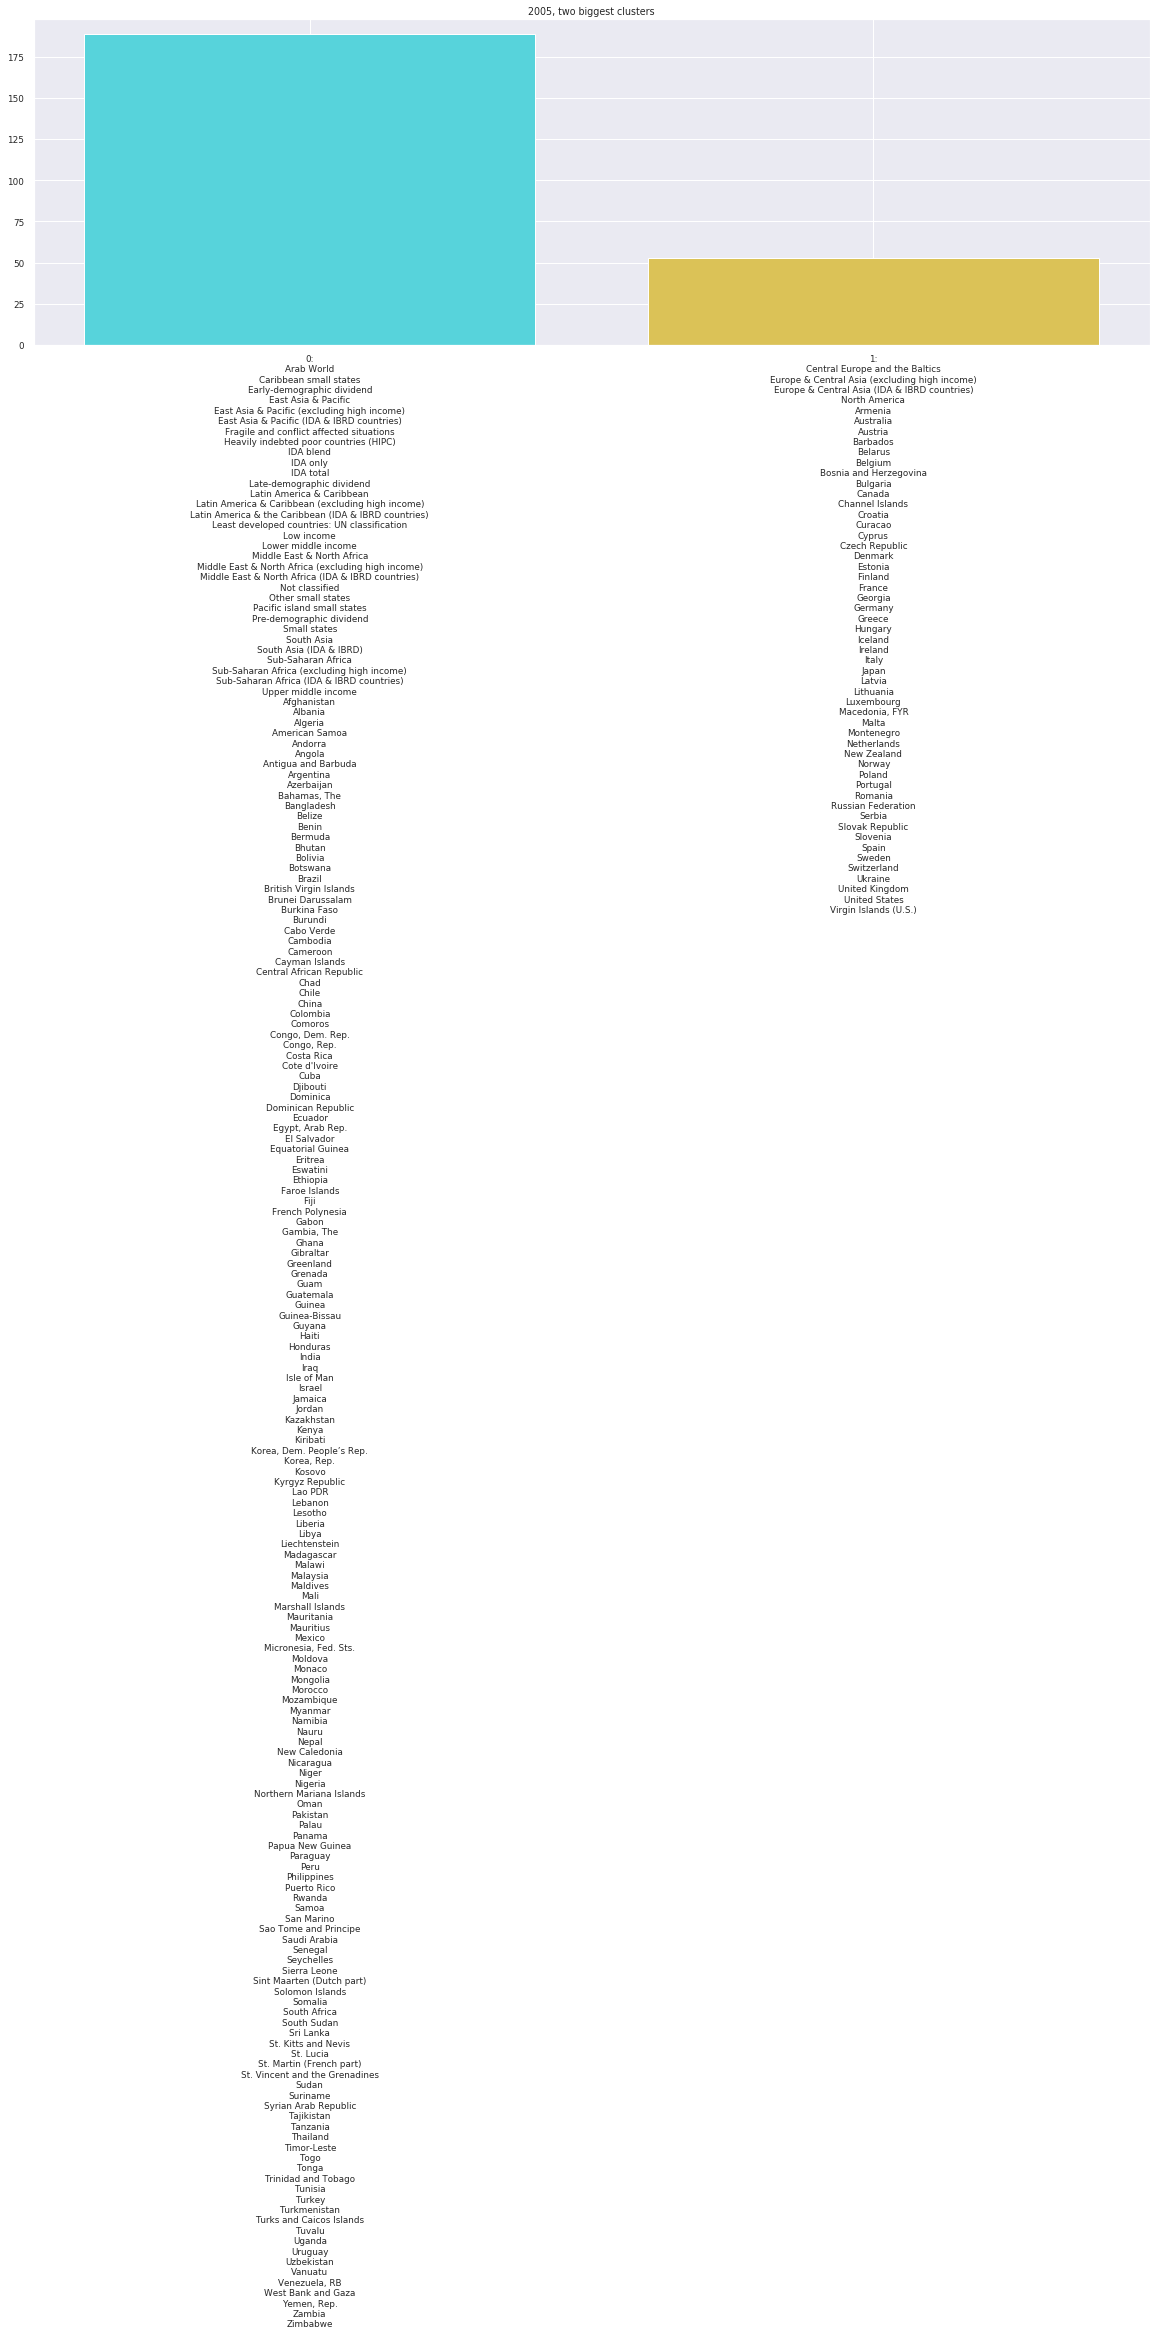

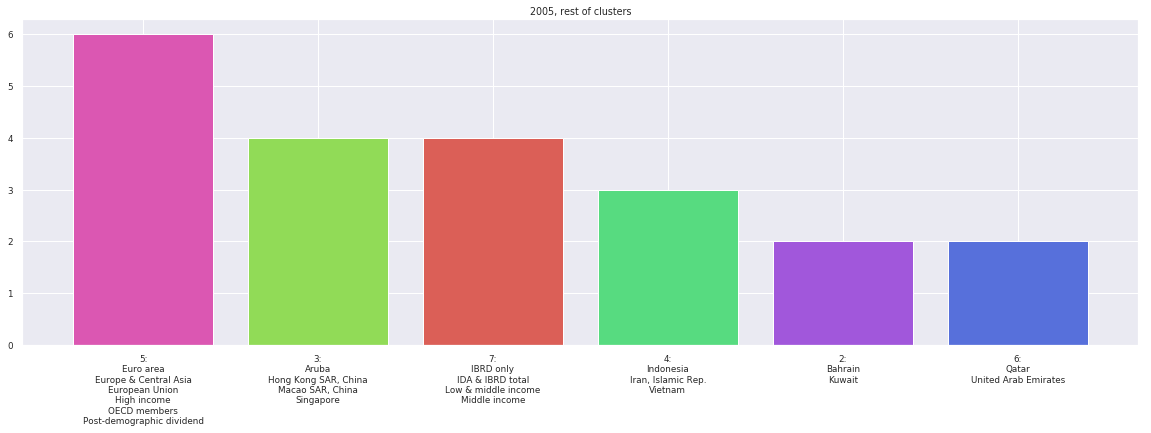

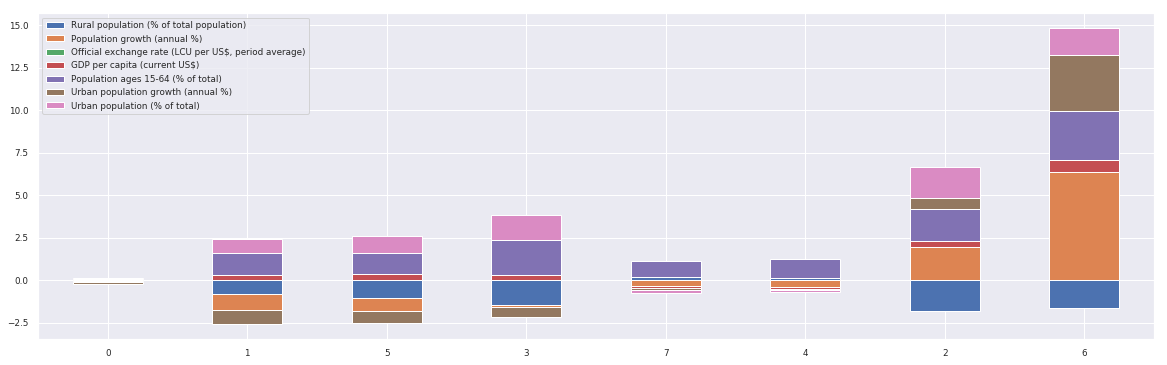

In [30]:
# возьмём несколько годов и посмотрим на содержимое
#   кластеров, а также на некоторые признаки в этих кластерах.
# цвета кластеров совпадают с цветами на графике-таблице выше.
# значения признаков на графике были стандартизованы по всем странам и годам.
# (сорри за отвратительно длинные графики)
# но по ним сложно что-то понять о различиях между кластерами.

for year in [1974, 1986, 1992, 2005]:
    i = year - years[0]
    df_ = df_years[i].loc[countries_chosen_idx, indicators_chosen]
    df_.fillna(df_.mean())
    df_ = ((df_ - df_mean[indicators_chosen])
           / (df_std[indicators_chosen] + 0.1))
    clusters = df_.groupby(clusters_labels[i].astype(int))
    details = np.array(
        [f'{j}:\n' + '\n'.join(
            countries_chosen[clusters_labels[i] == j]
        ) for j in range(n_clusters)]
    )
    sorted_idx = np.argsort(-clusters.size())
    sorted_cmap = np.array(cmap)[sorted_idx]
    sorted_cmap = [tuple(color) for color in sorted_cmap]

    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)
    plt.bar(np.arange(2), clusters.size()[sorted_idx][:2],
            color=sorted_cmap[:2])
    plt.xticks(np.arange(2), details[sorted_idx][:2])
    ax.xaxis.set_label_position('top')
    plt.xlabel(f"{year}, two biggest clusters")

    fig = plt.figure(figsize=(20, 6))
    plt.bar(np.arange(n_clusters - 2), clusters.size()[sorted_idx][2:],
            color=sorted_cmap[2:])
    ax = fig.add_subplot(111)
    plt.xticks(np.arange(n_clusters - 2), details[sorted_idx][2:])
    ax.xaxis.set_label_position('top')
    plt.xlabel(f"{year}, rest of clusters")

    clusters[indicators_for_plot].mean().loc[sorted_idx].plot.bar(
        figsize=(20, 6), stacked=True
    )
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=0)

In [ ]:
# Не переживайте, мне тоже было тяжело разобраться с данными

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

***Ваше ответ здесь***

Для выявления закономерностей в данных, которые не видны невооруженным глазом. Для выявления групп объектов и объектов-выбросов.

* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

***Ваше ответ здесь***

k-means:

(+) очень простой в реализации и понимании

(-) кластеры имеют сферическую форму

dbscan:

(+) количество кластеров не нужно задавать заранее

(-) не работает на различных плотностях кластеров

агломеративная кластеризация:

(+) наглядно представляется дендрограммой

(+) разнообразие linkage

(-) ресурсоемкий

* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со сккрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

***Ваше ответ здесь***

Если правдоподобие не ограничено...

* Многие алгоритмы анализа данных страдают "проклятием" размерности. Страдают ли этим проклятием алгоритмы кластеризации? Если да, то как бы Вы с этим боролись?

***Ваше ответ здесь***

Да, страдают. Ведь с ростом размерности теряется смысл расстояния, а алгоритмы кластеризации его используют. Методы борьбы - это уменьшение размерности: ручной и автоматический отбор признаков, PCA, t-SNE.

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

***Ваше ответ здесь***

Выдрал бы несколько слов, ярко характеризующих ту или иную тематику и часто употребляемых в рамках этой тематики (если более-менее знаю, на какие тематики буду разбивать), и для каждого документа отметил, сколько раз каждое из них в нём встречается. И запустил бы на этих признаках k-means или db-scan.

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

***Ваше ответ здесь***

Если эта часть охватывает все тематики, можно установить центры данных "кластеров" в качестве начальных центроид для k-means.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***

Странно распределены баллы, я потратил на данные в несколько раз больше времени, чем на алгоритм :D

Данные слишком большие и многогранные, слишком много возможностей для анализа, и сложно выбрать небольшое множество из всей кучи, чтобы можно было проанализировать результат глазами (и не очень понятно, как получить более-менее "непрерывную" кластеризацию по годам).

А данные для первичной проверки работы алгоритма слишком простые, на них постоянно выдаётся 1.0.